# Shor's Algorithm

Shor’s algorithm is famous for factoring integers in polynomial time. Since the best-known classical algorithm requires superpolynomial time to factor the product of two primes, the widely used cryptosystem, RSA, relies on factoring being impossible for large enough integers.

In this chapter we will focus on the quantum part of Shor’s algorithm, which actually solves the problem of _period finding_. Since a factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too. For now its enough to show that if we can compute the period of $a^x\bmod N$ efficiently, then we can also efficiently factor. Since period finding is a worthy problem in its own right, we will first solve this, then discuss how this can be used to factor in section 5.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
from tabulate import tabulate
from fractions import Fraction
print("Imports Successful")

Imports Successful


## 1. The Problem: Period Finding

Let’s look at the periodic function:

$$ f(x) = a^x \bmod{N}$$

<details>
    <summary>Reminder: Modulo &amp; Modular Arithmetic (Click here to expand)</summary>

The modulo operation (abbreviated to 'mod') simply means to find the remainder when dividing one number by another. For example:

$$ 17 \bmod 5 = 2 $$

Since $17 \div 5 = 3$ with remainder $2$. (i.e. $17 = (3\times 5) + 2$). In Python, the modulo operation is denoted through the <code>%</code> symbol.

This behaviour is used in <a href="https://en.wikipedia.org/wiki/Modular_arithmetic">modular arithmetic</a>, where numbers 'wrap round' after reaching a certain value (the modulus). Using modular arithmetic, we could write:

$$ 17 = 2 \pmod 5$$

Note that here the $\pmod 5$ applies to the entire equation (since it is in parenthesis), unlike the equation above where it only applied to the left-hand side of the equation.
</details>

where $a$ and $N$ are positive integers, $a$ is less than $N$, and they have no common factors. The period, or order ($r$), is the smallest (non-zero) integer such that:

$$a^r \bmod N = 1 $$ 

We can see an example of this function plotted on the graph below. Note that the lines between points are to help see the periodicity and do not represent the intermediate values between the x-markers.

Could not find period, check a < N and have no common factors.


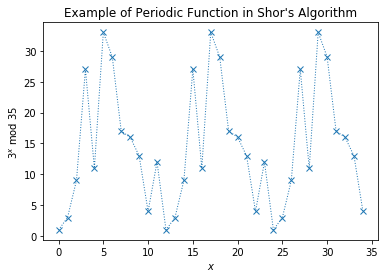

In [7]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

## 2. The Solution

Shor’s solution was to use [quantum phase estimation](./quantum-phase-estimation.html) on the unitary operator:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

To see how this is helpful, let’s work out what an eigenstate of U might look like. If we started in the state $|1\rangle$, we can see that each successive application of U will multiply the state of our register by $a \pmod N$, and after $r$ applications we will arrive at the state $|1\rangle$ again. For example with $a = 3$ and $N = 35$:

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}$$

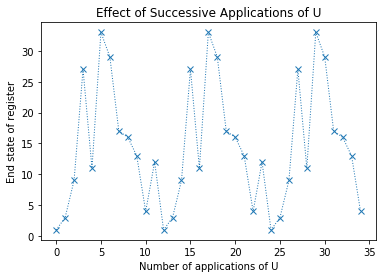

In [6]:
ax.set(xlabel='Number of applications of U', ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

So a superposition of the states in this cycle ($|u_0\rangle$) would be an eigenstate of $U$:

$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$


<details>
    <summary>Click to Expand: Example with $a = 3$ and $N=35$</summary>

$$\begin{aligned}
|u_0\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}$$
</details>


This eigenstate has an eigenvalue of 1, which isn’t very interesting. A more interesting eigenstate could be one in which the phase is different for each of these computational basis states. Specifically, let’s look at the case in which the phase of the $k$th state is proportional to $k$:

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle 
\end{aligned}
$$

<details>
    <summary>Click to Expand: Example with $a = 3$ and $N=35$</summary>

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{\tfrac{-2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle + e^{-\tfrac{6\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

(We can see $r = 12$ appears in the denominator of the phase.)
</details>

This is particularly interesting eigenvalue as it contains $r$. in fact, $r$ has to be included to make sure the phase differences between the $r$ computational basis states are equal. This is not the only eigenstate with this behaviour, to generalise this further, we can multiply an integer, $s$, to this phase difference, which will show up in our eigenvalue:

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle 
\end{aligned}
$$

<details>
    <summary>Click to Expand: Example with $a = 3$ and $N=35$</summary>

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|4\rangle + e^{-\tfrac{22\pi i s}{12}}|12\rangle) \\[10pt]
U|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i s}{12}}|9\rangle + e^{-\tfrac{4\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|12\rangle + e^{-\tfrac{22\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle + e^{-\tfrac{6\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i s}{12}}|12\rangle + e^{-\tfrac{24\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}|u_s\rangle
\end{aligned}$$

</details>

We now have a unique eigenstate for each integer value of $s$ where $0 < s < r-1$. Very conveniently, if we sum up all these eigenstates, the different phases cancel out all computational basis states except $|1\rangle$:

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

<details>
    <summary>Click to Expand: Example with $a = 7$ and $N=15$</summary>

For this, we will look at a smaller example where $a = 7$ and $N=15$. In this case $r=4$:

$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$

</details>

Since the computational basis state $|1\rangle$ is a superposition of these eigenstates, which means if we do QPE on $U$ using the state $|1\rangle$, we will measure a phase:

$$\phi = \frac{s}{r}$$

Where $s$ is a random integer between $0$ and $r-1$. We finally use the [continued fractions](https://en.wikipedia.org/wiki/Continued_fraction) algorithm on $\phi$ to find $r$. The circuit diagram looks like this (note that this diagram uses Qiskit's qubit ordering convention):

<img src="images/shor_circuit_1.svg">

We will next demonstrate Shor’s algorithm using Qiskit’s simulators. For this demonstration we will provide the circuits for $U$ without explanation, but in section 4 we will discuss how circuits for $U^{2^j}$ can be constructed efficiently.

## 3. Qiskit Implementation

In this example we will solve the period finding problem for $a=7$ and $N=15$. We provide the circuits for $U$ where:

$$U|y\rangle = |ay\bmod 15\rangle $$

without explanation. To create $U^x$, we will simply repeat the circuit $x$ times. In the next section we will discuss a general method for creating these circuits efficiently. The function `c_amod15` returns the controlled-U gate for `a`, repeated `power` times.

In [8]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

We will use 8 counting qubits:

In [9]:
# Specify variables
n_count = 8 # number of counting qubits
a = 7

We also provide the circuit for the inverse QFT (you can read more about the QFT in the [quantum Fourier transform chapter](./quantum-fourier-transform.html#generalqft)):

In [10]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

With these building blocks we can easily construct the circuit for Shor's algorithm:

In [11]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw('text')

┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐»
 q_8: ─────┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├»
           │             ││             ││             ││             │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├»
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐│             ││             ││             ││             │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c_0: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_1: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_2: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_3: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_4: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_5: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_6: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_7: ═════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
«             │               │                                         »
« q_6: ───────┼───────────────┼───────────────■────

Let's see what results we measure:

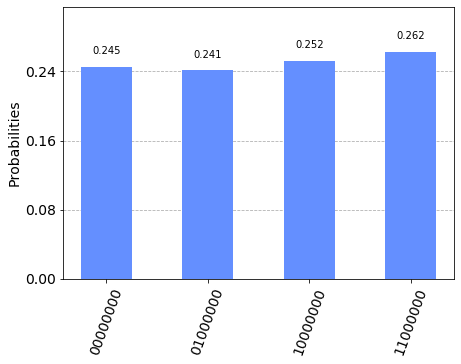

In [12]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

Since we have 3 qubits, these results correspond to measured phases of:

In [13]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Can use tabulate to print the rows this as a nice ASCII table:
print(tabulate(rows, 
               headers=["Register Output", "Phase"], 
               colalign=("left","right")))

Register Output                    Phase
------------------------  --------------
00000000(bin) = 0(dec)      0/256 = 0.00
01000000(bin) = 64(dec)    64/256 = 0.25
10000000(bin) = 128(dec)  128/256 = 0.50
11000000(bin) = 192(dec)  192/256 = 0.75


We can now use the continued fractions algorithm to attempt to find $s$ and $r$. Python has this functionality built in: We can use the `fractions` module to turn a float into a `Fraction` object, for example:

In [14]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [15]:
5998794703657501/9007199254740992

0.666

Because this gives fractions that return the result exactly (in this case, `0.6660000...`), this can give gnarly results like the one above. We can use the `.limit_denominator()` method to get the fraction that most closely resembles our float, with denominator below a certain value:

In [16]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

Much nicer! The order (r) must be less than N, so we will set the maximum denominator to be `15`:

In [17]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as nice ASCII table
print(tabulate(rows, 
               headers=["Phase", "Fraction", "Guess for r"], 
               colalign=('right','right','right')))

  Phase    Fraction    Guess for r
-------  ----------  -------------
      0         0/1              1
   0.25         1/4              4
    0.5         1/2              2
   0.75         3/4              4


We can see that two of the measured eigenvalues provided us with the correct result: $r=4$, and we can see that Shor’s algorithm has a chance of failing. These bad results are because $s = 0$, or because $s$ and $r$ are not coprime and instead of $r$ we are given a factor of $r$. The easiest solution to this is to simply repeat the experiment until we get a satisfying result for $r$.

### Quick Exercise

- Modify the circuit above for values of $a = 2, 8, 11$ and $13$. What results do you get and why?

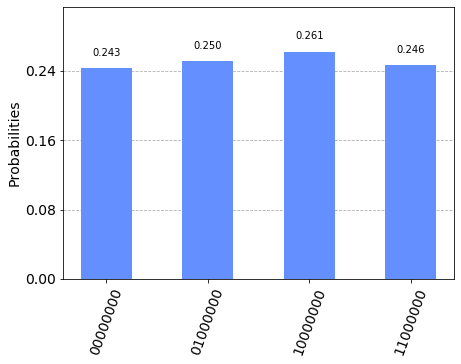

In [31]:
n_count = 8 # number of counting qubits
a = 8

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))

backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [32]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Can use tabulate to print the rows this as a nice ASCII table:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as nice ASCII table
print(tabulate(rows, 
               headers=["Phase", "Fraction", "Guess for r"], 
               colalign=('right','right','right')))

  Phase    Fraction    Guess for r
-------  ----------  -------------
      0         0/1              1
   0.25         1/4              4
    0.5         1/2              2
   0.75         3/4              4


## 4. Modular Exponentiation

You may have noticed that the method of creating the $U^{2^j}$ gates by repeating $U$ grows exponentially with $j$ and will not result in a polynomial time algorithm. We want a way to create the operator:

$$ U^{2^j}|y\rangle = |a^{2^j}y \bmod N \rangle $$

that grows polynomially with $j$. Fortunately, calculating:

$$ a^{2^j} \bmod N$$

efficiently is possible. Classical computers can use an algorithm known as _repeated squaring_ to calculate an exponential. In our case, since we are only dealing with exponentials of the form $2^j$, the repeated squaring algorithm becomes very simple:

In [33]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [34]:
a2jmodN(7, 2049, 53)

47

If an efficient algorithm is possible in Python, then we can use the same algorithm on a quantum computer. Unfortunately, despite scaling polynomially with $j$, modular exponentiation circuits are not straightforward and are the bottleneck in Shor’s algorithm. A beginner-friendly implementation can be found in reference [1].

## 5. Factoring from Period Finding

Not all factoring problems are difficult; we can spot an even number instantly and know that one of its factors is 2. In fact, there are [specific criteria](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.186-4.pdf#%5B%7B%22num%22%3A127%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C70%2C223%2C0%5D) for choosing numbers that are difficult to factor, but the basic idea is to choose the product of two large prime numbers.

A general factoring algorithm will first check to see if there is a shortcut to factoring the integer (is the number even? Is the number of the form $N = a^b$?), before using Shor’s period finding for the worst-case scenario. Since we aim to focus on the quantum part of the algorithm, we will jump straight to the case in which N is the product of two primes.

### Example: Factoring 15

To see an example of factoring on a small number of qubits, we will factor 15, which we all know is the product of the not-so-large prime numbers 3 and 5.

In [35]:
N = 15

The first step is to choose a random number, $x$, between $1$ and $N-1$:

In [36]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


Next we quickly check it isn't already a non-trivial factor of $N$:

In [37]:
from math import gcd # greatest common divisor
gcd(a, 15)

1

Great. Next, we do Shor's order finding algorithm for `a = 7` and `N = 15`. Remember that the phase we measure will be $s/r$ where:

$$ a^r \bmod N = 1 $$

and $s$ is a random integer between 0 and $r-1$.

In [38]:
def qpe_amod15(a):
    n_count = 3
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And ancilla register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    backend = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    result = execute(qc, backend, shots=1, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

From this phase, we can easily find a guess for $r$:

In [39]:
np.random.seed(3) # This is to make sure we get reproduceable results
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Register Reading: 100
Corresponding Phase: 0.500000


Fraction(1, 2)

In [40]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

2


Now we have $r$, we might be able to use this to find a factor of $N$. Since:

$$a^r \bmod N = 1 $$

then:

$$(a^r - 1) \bmod N = 0 $$

which mean $N$ must divide $a^r-1$. And if $r$ is also even, then we can write:

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

(if $r$ is not even, we cannot go further and must try again with a different value for $a$). There is then a high probability that the greatest common divisor of either $a^{r/2}-1$, or $a^{r/2}+1$ is a factor of $N$ [2]:

In [41]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 1]


The cell below repeats the algorithm until at least one factor of 15 is found. You should try re-running the cell a few times to see how it behaves.

In [45]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, 15), gcd(a**(r//2)+1, 15)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess != 1 and (15 % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 110
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


## 6. References

1. Stephane Beauregard, _Circuit for Shor's algorithm using 2n+3 qubits,_ [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)

2. M. Nielsen and I. Chuang, _Quantum Computation and Quantum Information,_ Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)

In [24]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}